In [1]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
train = np.loadtxt('../../002/data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../../002/data/digit/test.csv', delimiter=',', skiprows=1)

In [78]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Пробуем аугоментацию

Сначала прогоняем без аугументации для того, что бы получать более точные данные на валидации и что бы быстрее обучалось.
Аугументацию добавляем потом

In [79]:
import numpy as np

def rotateImage(image, angle):
  image_center = tuple(np.array(image.shape)/2)
  rot_mat = cv2.getRotationMatrix2D(image_center,angle,1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape,flags=cv2.INTER_LINEAR)
  return result

In [80]:
tstimg = train_img[3].copy()

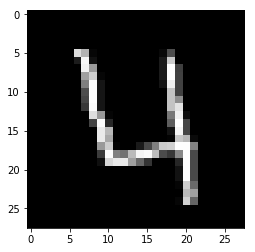

In [81]:
plt.imshow(tstimg, cmap='gray')

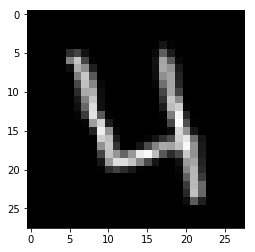

In [82]:
plt.imshow(rotateImage(tstimg,5), cmap='gray')

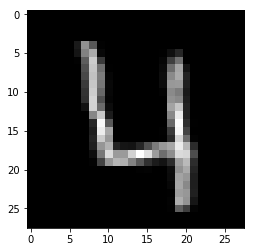

In [83]:
plt.imshow(rotateImage(tstimg,-5), cmap='gray')

In [84]:
train_img.shape

(42000, 28, 28)

In [85]:
train_img_a =np.zeros((3*train_img.shape[0], 28,28))
i=0

In [86]:
for img in train_img:
    train_img_a[i] = img
    i+=1

In [87]:
for img in train_img:
    train_img_a[i] = rotateImage(img,5)
    i+=1

In [88]:
for img in train_img:
    train_img_a[i] = rotateImage(img,-5)
    i+=1

In [89]:
train_label_a = np.hstack((train_label,train_label,train_label ))

train_label_a.shape

In [92]:
train_label_a = np.hstack((train_label_a, wronglabels_true_a))

## Визуализируем исходные данные

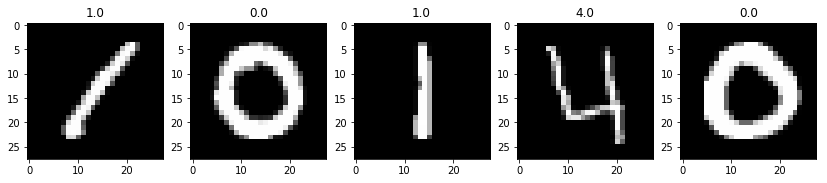

In [93]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [94]:
train_img = train_img_a.copy()
train_label = train_label_a.copy()

## Очищаем исходные данные

In [95]:
for i,img in enumerate(train_img):
    train_img[i] = cv2.GaussianBlur(img,ksize=(3,3),sigmaX =2.5)

In [96]:
for i,img in enumerate(test_img):
    test_img[i] = cv2.GaussianBlur(img,ksize=(3,3),sigmaX =2.5)

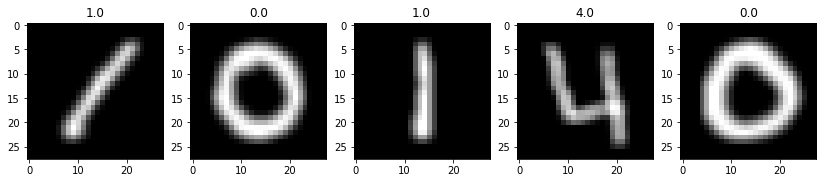

In [97]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);


## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [98]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=5)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=5)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=5)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=5)

## Вычисляем угол и длину вектора градиента

In [99]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

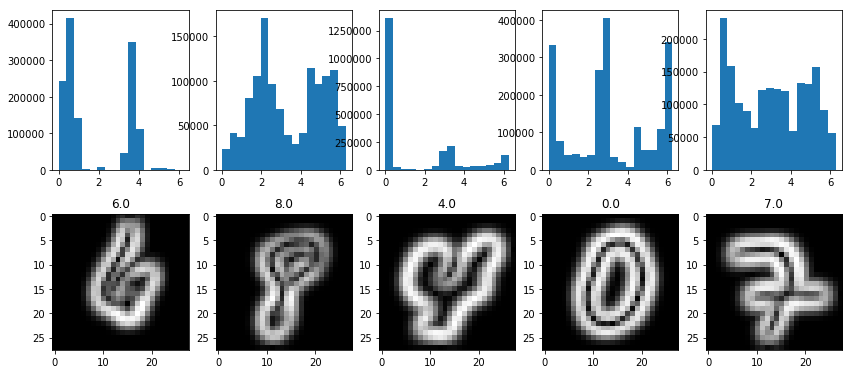

In [100]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[289:294], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[289+i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[289+i - 1].flatten())

## Вычисляем гистограммы градиентов

In [101]:
train_hist = np.zeros((len(train_img), 16*4))
for i in range(len(train_img)):
    hist_up_r, borders_up_r = np.histogram(train_theta[i][:14,:14],
                                 bins=16,
                                 range=(0.,  2*np.pi),
                                 weights=train_g[i][0:14,:14])
    hist_down_r, borders_down_r = np.histogram(train_theta[i][14:,:14],
                                 bins=16,
                                 range=(0.,  2*np.pi),
                                 weights=train_g[i][14:,:14])    
    hist_up_l, borders_up_l = np.histogram(train_theta[i][:14,14:],
                                 bins=16,
                                 range=(0.,  2*np.pi),
                                 weights=train_g[i][0:14,14:])
    hist_down_l, borders_down_l = np.histogram(train_theta[i][14:,14:],
                                 bins=16,
                                 range=(0.,  2*np.pi),
                                 weights=train_g[i][14:,14:])     
    train_hist[i] = np.hstack([hist_up_r, hist_down_r,hist_up_l, hist_down_l]) 

In [102]:
test_hist = np.zeros((len(test_img), 16*4))
for i in range(len(test_img)):
    hist_up_r, borders_up_r = np.histogram(test_theta[i][:14,:14],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=test_g[i][:14,:14])
    hist_down_r, borders_down_r = np.histogram(test_theta[i][14:,:14],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=test_g[i][14:,:14])    
    hist_up_l, borders_up_l = np.histogram(test_theta[i][:14,14:],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=test_g[i][:14,14:])
    hist_down_l, borders_down_l = np.histogram(test_theta[i][14:,14:],
                                 bins=16,
                                 range=(0., 2*np.pi),
                                 weights=test_g[i][14:,14:])        

    test_hist[i] = np.hstack([hist_up_r, hist_down_r,hist_up_l, hist_down_l])   

## Нормируем вектор гистограммы

In [ ]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

 ## Increase Degree

In [103]:
 (train_hist.shape[1]*(train_hist.shape[1] - 1)/2) + train_hist.shape[1]

2080.0

In [104]:
dim_d2 =  int((train_hist.shape[1]*(train_hist.shape[1] - 1)/2) + train_hist.shape[1])

In [105]:
train_hist_d2 = np.zeros((train_hist.shape[0], dim_d2))

In [106]:
col=0
for i in range(train_hist.shape[1]):
    for j in range(i,train_hist.shape[1]):
        train_hist_d2[:,col] = train_hist[:,i]*train_hist[:,j]
        col +=1

In [107]:
train_hist_d2 = np.hstack((train_hist, train_hist_d2))

In [108]:
#dim_d3 =  int((train_hist.shape[1]*(train_hist.shape[1] - 1)*(train_hist.shape[1] - 2)/6) + train_hist.shape[1])

In [109]:
test_hist_d2 = np.zeros((test_hist.shape[0], dim_d2))

In [110]:
col=0
for i in range(test_hist.shape[1]):
    for j in range(i,test_hist.shape[1]):
        test_hist_d2[:,col] = test_hist[:,i]*test_hist[:,j]
        col +=1

In [111]:
test_hist_d2 = np.hstack((test_hist, test_hist_d2))

In [112]:
train_hist_d2 = train_hist_d2 / np.linalg.norm(train_hist_d2, axis=1)[:, None]
test_hist_d2 = test_hist_d2 / np.linalg.norm(test_hist_d2, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [113]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist_d2, test_size=0.2, random_state=42)

In [36]:
x_train.shape

(100800, 2144)

## Собираем полносвязную сеть для обучения

In [37]:
from keras.activations import elu
from keras.layers import Conv1D, MaxPool1D, BatchNormalization

In [38]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(600, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2)) # для того что бы избежать переобучения
model.add(keras.layers.Dense(600, activation='relu'))
model.add(Dropout(0.2)) # для того что бы избежать переобучения
model.add(keras.layers.Dense(20, activation='relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Выводим информацию о модели

In [233]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 800)               1716000   
_________________________________________________________________
dropout_25 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 600)               480600    
_________________________________________________________________
dropout_26 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 20)                12020     
_________________________________________________________________
batch_normalization_5 (Batch (None, 20)                80        
_________________________________________________________________
dense_54 (Dense)             (None, 10)                210       
Total para

## One hot encoding разметки

In [40]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

## Запускаем обучение

In [ ]:
model.fit(x_train, y_train_labels, batch_size=128, epochs=20)

Epoch 1/20
 68736/100800 [===================>..........] - ETA: 16s - loss: 0.1734 - acc: 0.9520 

## Предсказываем класс объекта

In [42]:
pred_val = model.predict_classes(x_val)

24960/25200 [============================>.] - ETA: 0s 

## Оцениваем качество решение на валидационной выборке

In [43]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))
# после размножения картинок качество на валидации перестает быть показательным. 

Accuracy: 0.990992063492


In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00      2485
        1.0       1.00      0.99      0.99      2864
        2.0       0.99      0.99      0.99      2513
        3.0       0.99      0.98      0.99      2564
        4.0       0.99      0.99      0.99      2481
        5.0       0.99      0.99      0.99      2312
        6.0       0.99      1.00      0.99      2442
        7.0       0.99      0.99      0.99      2637
        8.0       0.99      0.99      0.99      2335
        9.0       0.99      0.99      0.99      2567

avg / total       0.99      0.99      0.99     25200



In [45]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[2472    0    0    1    0    0    4    1    5    2]
 [   0 2848    1    0    0    0   10    2    2    1]
 [   0    3 2493    6    0    0    2    6    3    0]
 [   0    0   19 2525    0    9    1    4    5    1]
 [   0    4    0    0 2460    0    4    2    1   10]
 [   0    0    0   11    0 2292    4    0    5    0]
 [   0    0    0    0    5    1 2433    0    3    0]
 [   0    3    8    2    3    0    0 2616    0    5]
 [   0    3    4    0    6    2    8    1 2305    6]
 [   0    1    2    4    8    3    0   12    8 2529]]


## Посмотрим те цифры, на которых мы ошиблись

In [46]:
wrongimg = x_val[np.nonzero(y_val!=pred_val)]

In [47]:
wrongimg.shape

(227, 2144)

In [ ]:
pred_val_alltr = model.predict_classes(train_hist_d2)

106368/126000 [========================>.....] - ETA: 5s  

In [51]:
wrongimg = train_img[np.nonzero(train_label!=pred_val_alltr)]
wronglabels = pred_val_alltr[np.nonzero(train_label!=pred_val_alltr)]
train_g_w=train_g[np.nonzero(train_label!=pred_val_alltr)]
train_theta_w = train_theta[np.nonzero(train_label!=pred_val_alltr)]
wronglabels_true = train_label[np.nonzero(train_label!=pred_val_alltr)]

In [52]:
wrongimg.shape

(355, 28, 28)

In [53]:
train_label[289]

6.0

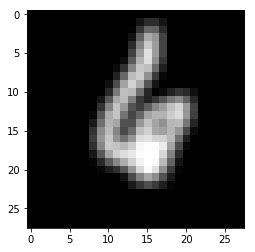

In [158]:
plt.imshow(train_img[289], cmap='gray')

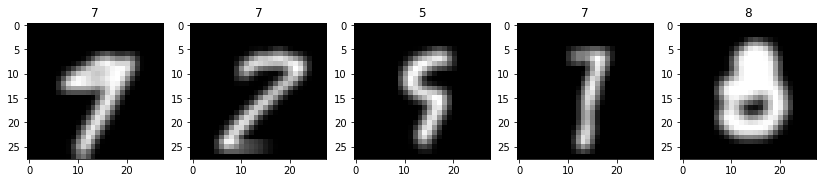

In [54]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(wrongimg[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % wronglabels[i - 1]);


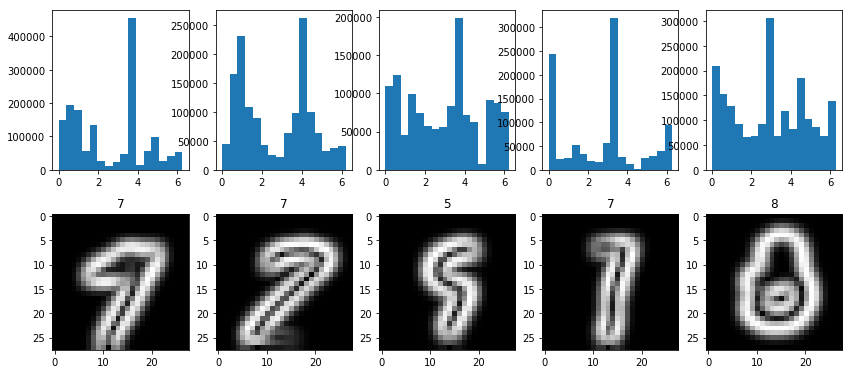

In [55]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g_w[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % wronglabels[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta_w[i - 1].flatten(),
             bins=16, weights=train_g_w[i - 1].flatten())

## Предсказания на тестовыйх данных

In [114]:
train_labels_dummy = np_utils.to_categorical(train_label)

In [ ]:
train_labels_dummy.shape

(170375, 10)

In [ ]:
model.fit(train_hist_d2, train_labels_dummy, batch_size=128, epochs=20)

Epoch 1/20
128384/170375 [=====================>........] - ETA: 24s - loss: 0.0132 - acc: 0.9959 

In [277]:
pred_test = model.predict_classes(test_hist_d2)

27968/28000 [============================>.] - ETA: 0s  

## Визуализируем предсказания

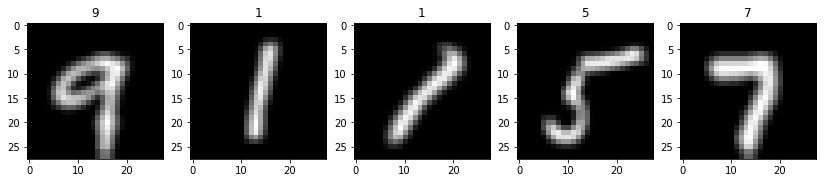

In [280]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[20:25], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[20+i - 1]);

## Готовим файл для отправки

In [281]:
with open('submit_a_gusbl.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
# Your submission scored 0.59843

In [ ]:
# My submission scored 0.98414